### (2016, Natrue Genetics)

In [60]:
import os, time, pickle, musical
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import scipy as sp


class PublicData:
    def __init__ ( self, INPUT_PATH, PROJECT_NAME, PROJECT_DIR):
        self.input_df = pd.read_csv ( INPUT_PATH, sep = "," )
        self.PROJECT_NAME = PROJECT_NAME
        self.PROJECT_DIR = PROJECT_DIR
        if os.path.exists ( self.PROJECT_DIR ):
            os.system ("rm -rf " + self.PROJECT_DIR)
        if not os.path.exists ( self.PROJECT_DIR ):
            os.system ("mkdir -p " + self.PROJECT_DIR)

    def select_NF2_containing_sample ( self ):
        NF_containing_sample = list ( self.input_df [ self.input_df["Gene"] == "NF2"] ["SAMPLEID"])
        self.input_df = self.input_df [ self.input_df["SAMPLEID"].isin(NF_containing_sample) ].reset_index(drop = True)        # NF2 positive 인 tumor 만 하고 싶다면

    def make_matrix (self):
        self.SigProfMatrix = pd.DataFrame (  columns = ["Project", "Sample", "ID", "Genome", "mut_type", "chrom",	"pos_start","pos_end",	"ref",	"alt"	,"Type"] ) 
        self.SigProfMatrix ["ID"] = self.input_df ["SAMPLEID"] + "_" + self.input_df["CHROM"].astype(str) + ":" + self.input_df["POS"].astype(str)
        self.SigProfMatrix ["Genome"] = "GRCh37"
        self.SigProfMatrix ["mut_type"] = "SNP"
        self.SigProfMatrix ["chrom"] = self.input_df["CHROM"]
        self.SigProfMatrix ["pos_start"] = self.input_df["POS"]
        self.SigProfMatrix ["pos_end"] = self.input_df["POS"]
        self.SigProfMatrix ["ref"] = self.input_df["REF"]
        self.SigProfMatrix ["alt"] = self.input_df["ALT"]
        self.SigProfMatrix ["Type"] = "SOMATIC"
        self.SigProfMatrix  ["Project"] = self.PROJECT_NAME
        self.SigProfMatrix  ["Sample"] = self.PROJECT_NAME
        self.SigProfMatrix ['mut_type'] = [
            'SNP' if len(ref) == len(alt) else 'DEL' if len(ref) > len(alt) else 'IND'
            for ref, alt in zip(self.SigProfMatrix['ref'], self.SigProfMatrix ['alt'])
        ]
        self.SigProfMatrix.to_csv ( self.PROJECT_DIR + "/Matrix.txt", sep = "\t", index = False)

    def MatrixGenerator (self):
        # Matrix Generator
        from SigProfilerMatrixGenerator.scripts import SigProfilerMatrixGeneratorFunc as matGen
        matrices = matGen.SigProfilerMatrixGeneratorFunc ( self.PROJECT_NAME,  # project
                                                                                            "GRCh37",   # reference_genome
                                                                                            self.PROJECT_DIR,  # path_to_input_files 
                                                                                            exome = False, 
                                                                                            bed_file = None, 
                                                                                            chrom_based  = False, 
                                                                                            plot = True, 
                                                                                            tsb_stat = False, 
                                                                                            seqInfo = True)
    def Single_base (self):
        self.df_singlebase = pd.read_csv ( self.PROJECT_DIR  + "/output/SBS/" + self.PROJECT_NAME + ".SBS6.all", sep = "\t", index_col = 0 )
        self.df_singlebase_percentage = round ( ( self.df_singlebase / self.df_singlebase.sum(axis=0) ) * 100 ) 
        self.df_singlebase_percentage ["MutationType"] = self.df_singlebase_percentage.index
        self.df_singlebase_percentage_long = pd.melt ( self.df_singlebase_percentage , id_vars = "MutationType", var_name = "classification", value_name = "percent")

    def Three_base (self):
        self.X = pd.read_csv(  self.PROJECT_DIR + "/output/SBS/" + self.PROJECT_NAME + ".SBS96.all", index_col=0, sep  = "\t")
        self.X.index.name = 'Type'
        self.X = self.X.loc [ musical.load_catalog('COSMIC-MuSiCal_v3p2_SBS_WGS').W.index , : ]   # 순서를 잘 정해줄 필요가 있다

    def Musical_denovo (self):
        self.model = musical.DenovoSig( self.X, 
                          min_n_components = 1, # Minimum number of signatures to test
                          max_n_components = 5, # Maximum number of signatures to test
                          init = 'random', # Initialization method
                          method = 'mvnmf', # mvnmf or nmf
                          n_replicates = 10, # Number of mvnmf/nmf replicates to run per n_components
                          ncpu = 8, # Number of CPUs to use
                          max_iter = 10000, # Maximum number of iterations for each mvnmf/nmf run
                          bootstrap = True, # Whether or not to bootstrap X for each run
                          tol = 1e-8, # Tolerance for claiming convergence of mvnmf/nmf
                          verbose = 0, # Verbosity of output
                          normalize_X=False # Whether or not to L1 normalize each sample in X before mvnmf/nmf
                         )
        self.model.fit()

        #print(model.n_components)
        #model.W_df
        self.model.plot_selection()
        self.fig_denovo = musical.sigplot_bar ( self.model.W)

    def Musical_refitting (self, W_catalog, thresh_grid):
        self.model.assign_grid(W_catalog, 
                method_assign = 'likelihood_bidirectional', # Method for performing matching and refitting
                thresh_match_grid = thresh_grid, # Grid of threshold for matchinng
                thresh_refit_grid = thresh_grid, # Grid of threshold for refitting
                thresh_new_sig = 0.0, # De novo signatures with reconstructed cosine similarity below this threshold will be considered novel
                connected_sigs = False, # Whether or not to force connected signatures to co-occur
                clean_W_s = False # An optional intermediate step to avoid overfitting to small backgrounds in de novo signatures for 96-channel SBS signatures
        )
        print( self.model.H_s_grid[(0.01, 0.01)] )
        print( self.model.H_s_grid[(0.001, 0.001)] )



In [61]:
NATGEN_WHOLE = PublicData ( "/data/project/Meningioma/99.Meningioma_public/NatGen/41588_2016_BFng3651_MOESM63_ESM.csv",
                                                        "NATGEN_WHOLE",
                                                        "/data/project/Meningioma/41.Signature/11.PublicData/01.NatGen_whole")
NATGEN_NF2 = PublicData ( "/data/project/Meningioma/99.Meningioma_public/NatGen/41588_2016_BFng3651_MOESM63_ESM.csv",
                                                        "NATGEN_NF2",
                                                        "/data/project/Meningioma/41.Signature/11.PublicData/02.NatGen_NF2")
SCIENCE_WHOLE = PublicData ( "/data/project/Meningioma/99.Meningioma_public/Science/2013_Science_Clark.csv",
                                                        "SCIENCE_WHOLE",
                                                        "/data/project/Meningioma/41.Signature/11.PublicData/03.Science_whole")
SCIENCE_NF2 = PublicData ( "/data/project/Meningioma/99.Meningioma_public/Science/2013_Science_Clark.csv",
                                                        "SCIENCE_NF2",
                                                        "/data/project/Meningioma/41.Signature/11.PublicData/04.Science_NF2")

In [62]:
NATGEN_NF2.select_NF2_containing_sample ()
SCIENCE_NF2.select_NF2_containing_sample ()

NATGEN_WHOLE.make_matrix()
NATGEN_NF2.make_matrix()
SCIENCE_WHOLE.make_matrix()
SCIENCE_NF2.make_matrix()

NATGEN_WHOLE.MatrixGenerator()
NATGEN_NF2.MatrixGenerator()
SCIENCE_WHOLE.MatrixGenerator()
SCIENCE_NF2.MatrixGenerator()

NATGEN_WHOLE.Single_base()
NATGEN_NF2.Single_base()
SCIENCE_WHOLE.Single_base()
SCIENCE_NF2.Single_base()

NATGEN_WHOLE.Three_base()
NATGEN_NF2.Three_base()
SCIENCE_WHOLE.Three_base()
SCIENCE_NF2.Three_base()

Starting matrix generation for SNVs and DINUCs...There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 32 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'G', 'H', 'L', 'N', 'O', 'T', 'W', 'a', 'b', 'c', 'colon', 'comma', 'd', 'e', 'greater', 'i', 'n', 'nine', 'nonmarkingreturn', 'one', 'r', 's', 'seven', 'space', 't', 'u', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 15, 20, 26, 28, 29, 33, 36, 38, 40, 42, 43, 47, 49, 50, 55, 58, 66, 68, 69, 70, 71, 72, 76, 81, 85, 86, 87, 88]
INFO - Closed glyph list over 'GSUB': 32 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'G', 'H', 'L', 'N', 'O', 'T', 'W', 'a', 'b', 'c', 'colon', 'comma', 'd', 'e', 'greater', 'i', 'n', 'nine', 'nonmarkingreturn', 'one', 'r', 's', '

There may be an issue with the formatting of your matrix file.
There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 31 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'G', 'H', 'L', 'N', 'O', 'T', 'W', 'a', 'b', 'c', 'colon', 'd', 'e', 'greater', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't', 'two', 'u', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 21, 29, 33, 36, 38, 40, 42, 43, 47, 49, 50, 55, 58, 66, 68, 69, 70, 71, 72, 76, 79, 81, 82, 85, 86, 87, 88]
INFO - Closed glyph list over 'GSUB': 31 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'G', 'H', 'L', 'N', 'O', 'T', 'W', 'a', 'b', 'c', 'colon', 'd', 'e', 'greater', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't', 'two', 'u', 'undersco

Completed! Elapsed time: 13.06 seconds.
Starting matrix generation for INDELs...There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 24 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'E', 'G', 'H', 'L', 'N', 'O', 'T', 'W', 'colon', 'd', 'e', 'eight', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'one', 's', 'space', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 20, 23, 27, 29, 36, 40, 42, 43, 47, 49, 50, 55, 58, 66, 71, 72, 76, 79, 81, 86]
INFO - Closed glyph list over 'GSUB': 24 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'E', 'G', 'H', 'L', 'N', 'O', 'T', 'W', 'colon', 'd', 'e', 'eight', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 'one', 's', 'space', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 20, 23, 27, 29, 36, 40, 42, 43, 47, 49, 50, 55, 58, 66, 71

Completed! Elapsed time: 5.19 seconds.
Matrices generated for 1 samples with 189 errors. Total of 2092 SNVs, 3 DINUCs, and 502 INDELs were successfully analyzed.
Starting matrix generation for SNVs and DINUCs...There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 29 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'N', 'T', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'five', 'greater', 'i', 'n', 'nonmarkingreturn', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 21, 22, 24, 27, 29, 33, 36, 38, 40, 41, 42, 49, 55, 66, 68, 69, 70, 71, 72, 76, 81, 85, 86, 87, 88]
INFO - Closed glyph list over 'GSUB': 29 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'N', 'T', 'a', 'b', 'c', 'colon', 'd', 'e', 'eight', 'five', 'greater', 'i', 'n', 'nonmarkingreturn', 'r', 's', 'space', 't', 'three', 'two', 'u', 'underscore']
I

There may be an issue with the formatting of your matrix file.
Completed! Elapsed time: 11.01 seconds.
Starting matrix generation for INDELs...There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 21 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'E', 'F', 'G', 'N', 'T', 'colon', 'd', 'e', 'eight', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 's', 'space', 'two', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 21, 23, 27, 29, 36, 40, 41, 42, 49, 55, 66, 71, 72, 76, 79, 81, 86]
INFO - Closed glyph list over 'GSUB': 21 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'E', 'F', 'G', 'N', 'T', 'colon', 'd', 'e', 'eight', 'four', 'i', 'l', 'n', 'nonmarkingreturn', 's', 'space', 'two', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 21, 23, 27, 29, 36, 40, 41, 42, 49, 55, 66, 71, 72, 76, 79, 81, 86]
INFO - Closing glyph list over '

Completed! Elapsed time: 4.85 seconds.
Matrices generated for 1 samples with 10 errors. Total of 384 SNVs, 0 DINUCs, and 129 INDELs were successfully analyzed.
Starting matrix generation for SNVs and DINUCs...There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 33 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'G', 'H', 'I', 'L', 'N', 'O', 'S', 'T', 'W', 'a', 'b', 'c', 'colon', 'd', 'e', 'greater', 'i', 'n', 'nonmarkingreturn', 'r', 's', 'seven', 'space', 't', 'three', 'u', 'underscore', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 22, 26, 29, 33, 36, 38, 40, 42, 43, 44, 47, 49, 50, 54, 55, 58, 66, 68, 69, 70, 71, 72, 76, 81, 85, 86, 87, 88]
INFO - Closed glyph list over 'GSUB': 33 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'G', 'H', 'I', 'L', 'N', 'O', 'S', 'T', 'W', 'a', 'b', 'c', 'colon', 'd', 'e', 'greater', 'i', 'n', 'nonmarkingreturn', 'r', 's', 'seven',

There may be an issue with the formatting of your matrix file.
There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 31 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'C', 'E', 'H', 'I', 'L', 'N', 'O', 'S', 'T', 'W', 'a', 'b', 'c', 'colon', 'd', 'e', 'greater', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't', 'u', 'underscore', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 29, 33, 38, 40, 43, 44, 47, 49, 50, 54, 55, 58, 66, 68, 69, 70, 71, 72, 76, 79, 81, 82, 85, 86, 87, 88]
INFO - Closed glyph list over 'GSUB': 31 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'C', 'E', 'H', 'I', 'L', 'N', 'O', 'S', 'T', 'W', 'a', 'b', 'c', 'colon', 'd', 'e', 'greater', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't', 'u', 'underscore', '

Completed! Elapsed time: 13.17 seconds.
Starting matrix generation for INDELs...There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 22 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'C', 'E', 'H', 'I', 'L', 'N', 'O', 'S', 'W', 'colon', 'd', 'e', 'i', 'l', 'n', 'nonmarkingreturn', 's', 'space', 'two', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 21, 29, 38, 40, 43, 44, 47, 49, 50, 54, 58, 66, 71, 72, 76, 79, 81, 86]
INFO - Closed glyph list over 'GSUB': 22 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'C', 'E', 'H', 'I', 'L', 'N', 'O', 'S', 'W', 'colon', 'd', 'e', 'i', 'l', 'n', 'nonmarkingreturn', 's', 'space', 'two', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 21, 29, 38, 40, 43, 44, 47, 49, 50, 54, 58, 66, 71, 72, 76, 79, 81, 86]
INFO - Closing glyph list ov

Completed! Elapsed time: 4.96 seconds.
Matrices generated for 1 samples with 0 errors. Total of 320 SNVs, 1 DINUCs, and 41 INDELs were successfully analyzed.
Starting matrix generation for SNVs and DINUCs...There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 30 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'N', 'S', 'T', 'a', 'b', 'c', 'colon', 'd', 'e', 'five', 'greater', 'i', 'n', 'nonmarkingreturn', 'one', 'r', 's', 'space', 't', 'two', 'u', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 20, 21, 24, 29, 33, 36, 38, 40, 41, 42, 44, 49, 54, 55, 66, 68, 69, 70, 71, 72, 76, 81, 85, 86, 87, 88]
INFO - Closed glyph list over 'GSUB': 30 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'A', 'C', 'E', 'F', 'G', 'I', 'N', 'S', 'T', 'a', 'b', 'c', 'colon', 'd', 'e', 'five', 'greater', 'i', 'n', 'nonmarkingreturn', 'one', 'r', 's', 'space', 't', 'two', 'u', 'underscore']

There may be an issue with the formatting of your matrix file.
There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 29 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'N', 'S', 'T', 'a', 'b', 'c', 'colon', 'd', 'e', 'greater', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 19, 21, 29, 33, 38, 40, 41, 44, 49, 54, 55, 66, 68, 69, 70, 71, 72, 76, 79, 81, 82, 85, 86, 87, 88]
INFO - Closed glyph list over 'GSUB': 29 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'N', 'S', 'T', 'a', 'b', 'c', 'colon', 'd', 'e', 'greater', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't', 'two', 'u', 'underscore', 'zero']
INFO - Glyph IDs:

Completed! Elapsed time: 13.62 seconds.
Starting matrix generation for INDELs...There may be an issue with the formatting of your matrix file.


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 21 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'N', 'S', 'colon', 'd', 'e', 'five', 'i', 'l', 'n', 'nonmarkingreturn', 'one', 's', 'space', 'two', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 20, 21, 24, 29, 38, 40, 41, 44, 49, 54, 66, 71, 72, 76, 79, 81, 86]
INFO - Closed glyph list over 'GSUB': 21 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'C', 'E', 'F', 'I', 'N', 'S', 'colon', 'd', 'e', 'five', 'i', 'l', 'n', 'nonmarkingreturn', 'one', 's', 'space', 'two', 'underscore']
INFO - Glyph IDs:   [0, 1, 2, 3, 20, 21, 24, 29, 38, 40, 41, 44, 49, 54, 66, 71, 72, 76, 79, 81, 86]
INFO - Closing glyph list over 'glyf

Completed! Elapsed time: 4.93 seconds.
Matrices generated for 1 samples with 0 errors. Total of 131 SNVs, 1 DINUCs, and 21 INDELs were successfully analyzed.


---

### 01. de novo signature discovery ( X만 있으면 됨. 5분 정도)

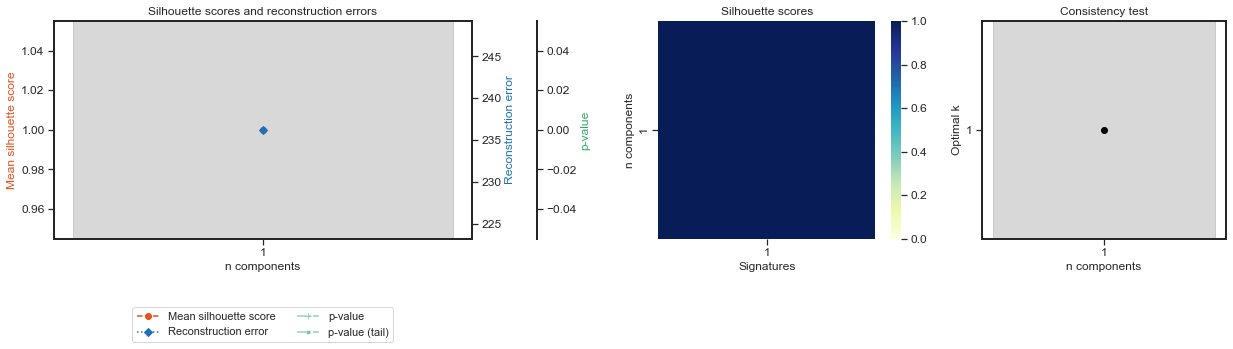

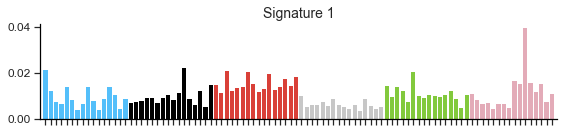

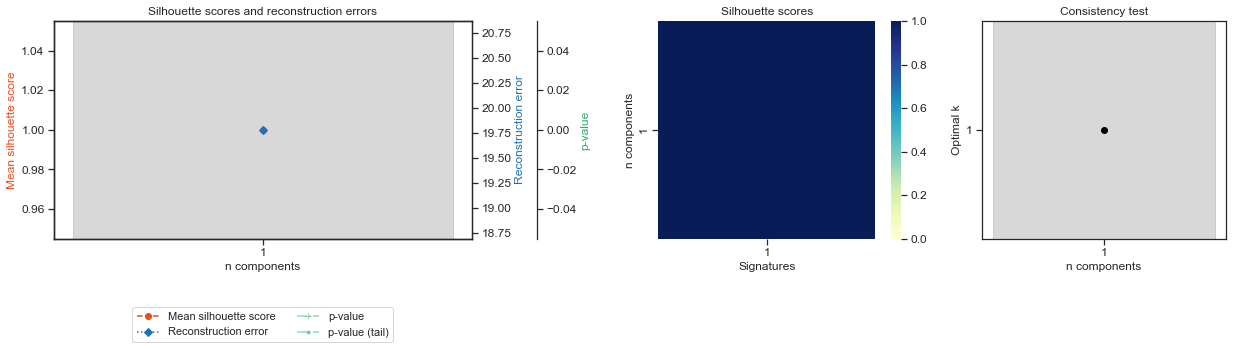

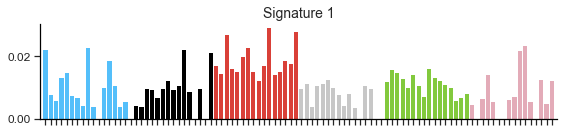

In [63]:
NATGEN_WHOLE.Musical_denovo()
NATGEN_NF2.Musical_denovo()

In [64]:
NATGEN_WHOLE.df_singlebase

,NATGEN_WHOLE
MutationType,
C>A,285
C>G,279
C>T,594
T>A,113
T>C,339
T>G,482


In [65]:
SCIENCE_WHOLE.df_singlebase

,SCIENCE_WHOLE
MutationType,
C>A,30
C>G,39
C>T,159
T>A,21
T>C,47
T>G,24


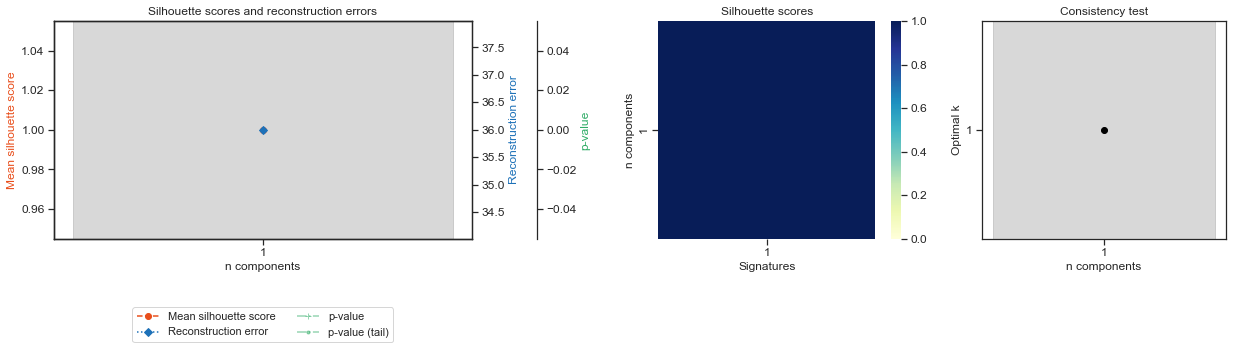

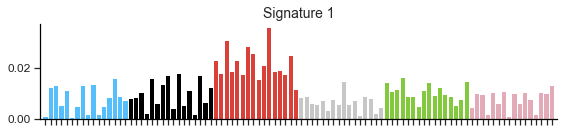

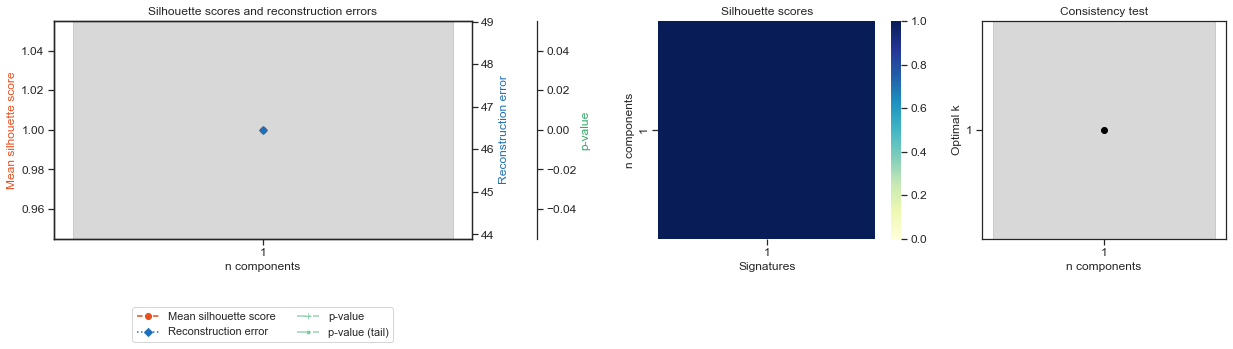

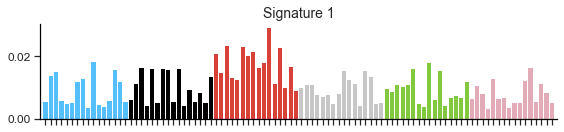

In [66]:

SCIENCE_WHOLE.Musical_denovo()
SCIENCE_NF2.Musical_denovo()

### 02. refitting & assignment (W를 통해 H를 구하는 과정)

In [76]:
thresh_grid = np.array([ 0.0001, 0.001, 0.01, 0.1, 0.2  ])

print ( musical.catalog.CATALOG_NAMES  )
catalog = musical.load_catalog('COSMIC-MuSiCal_v3p2_SBS_WGS')
print(catalog.show_tumor_type_options().tolist())           # Tumor에만 있는 signature로 한정하자
# TUMOR_TYPE = "CNS.GBM"
# catalog.restrict_catalog(tumor_type = TUMOR_TYPE)
# print ( "\n\n{} → {}개의 mutational context * {}개의 SBS signature\n\t\t{}".format ( TUMOR_TYPE,  catalog.W.shape[0],  catalog.W.shape[1], catalog.W.columns ) ) 
W_catalog = catalog.W.loc [:, ["SBS1", "SBS5", "SBS15",  "SBS16", "SBS18", "SBS21", "SBS88", "SBS91" ] ]
                            #["SBS1", "SBS2", "SBS4", "SBS5", "SBS13", "SBS16", "SBS18", "SBS21", "SBS35", "SBS88", "SBS91" ]]
#

['COSMIC_v2_SBS_WGS', 'COSMIC_v3_SBS_WGS', 'COSMIC_v3_SBS_WES', 'COSMIC_v3p1_SBS_WGS', 'COSMIC_v3p2_SBS_WGS', 'COSMIC-MuSiCal_v3p2_SBS_WGS', 'COSMIC_v3p1_Indel', 'MuSiCal_v4_Indel_WGS']
['Biliary.AdenoCA', 'Bladder.TCC', 'Bone.Benign', 'Bone.Epith', 'Bone.Osteosarc', 'Breast.AdenoCA', 'Breast.DCIS', 'Breast.LobularCA', 'CNS.GBM', 'CNS.Medullo', 'CNS.Oligo', 'CNS.PiloAstro', 'Cervix.AdenoCA', 'Cervix.SCC', 'ColoRect.AdenoCA', 'Eso.AdenoCA', 'Head.SCC', 'Kidney.ChRCC', 'Kidney.RCC', 'Liver.HCC', 'Lung.AdenoCA', 'Lung.SCC', 'Lymph.BNHL', 'Lymph.CLL', 'Myeloid.AML', 'Myeloid.MDS', 'Myeloid.MPN', 'Ovary.AdenoCA', 'Panc.AdenoCA', 'Panc.Endocrine', 'Prost.AdenoCA', 'Skin.Melanoma', 'SoftTissue.Leiomyo', 'SoftTissue.Liposarc', 'Stomach.AdenoCA', 'Thy.AdenoCA', 'Uterus.AdenoCA']


In [77]:
NATGEN_WHOLE.Musical_refitting (W_catalog, thresh_grid)
NATGEN_NF2.Musical_refitting (W_catalog, thresh_grid)
SCIENCE_WHOLE.Musical_refitting (W_catalog, thresh_grid)
SCIENCE_NF2.Musical_refitting (W_catalog, thresh_grid)

      NATGEN_WHOLE
SBS5    1477.43288
       NATGEN_WHOLE
SBS1     158.686627
SBS5    1236.679210
SBS18    206.207032
       NATGEN_NF2
SBS1    38.876712
SBS5   229.458366
SBS18   47.504294
       NATGEN_NF2
SBS1    38.876712
SBS5   229.458366
SBS18   47.504294
      SCIENCE_WHOLE
SBS1      61.514703
SBS5     223.047425
       SCIENCE_WHOLE
SBS1       61.582782
SBS5      220.838959
SBS91       4.560018
      SCIENCE_NF2
SBS1    27.737267
SBS5    81.122914
       SCIENCE_NF2
SBS1     27.754976
SBS5     80.548415
SBS91     1.186219


       SCIENCE_NF2
SBS1     25.349415
SBS5     73.567177
SBS91     1.083408


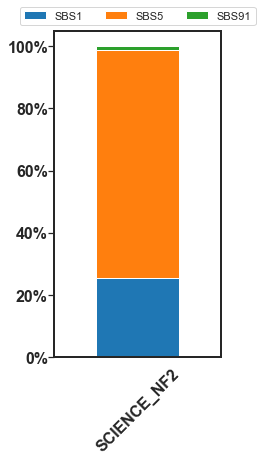

In [78]:
SCIENCE_NF2.model.H_s_percentage = (SCIENCE_NF2.model.H_s_grid[(0.001, 0.001)] / SCIENCE_NF2.model.H_s_grid[(0.001, 0.001)].sum(axis=0) ) * 100
print ( SCIENCE_NF2.model.H_s_percentage )

import matplotlib.pyplot as plt
import seaborn as sns
import palettable
import random

plt.rcParams["font.family"] = 'arial'
fig, ax = plt.subplots ( nrows = 1, ncols = 1, figsize = (3, 6))

tabl = random.shuffle ( palettable.tableau.Tableau_20.mpl_colors )
vivid_10 = random.shuffle  ( palettable.cartocolors.qualitative.Vivid_10.mpl_colors )

SCIENCE_NF2.model.H_s_percentage.T.plot( kind = 'bar', stacked = True, color = vivid_10, ax = ax)
ax.set_xticklabels( SCIENCE_NF2.model.H_s_percentage.columns, ha = "center",  fontdict = {"fontsize": 16, "fontweight" : 'bold' } )
ax.set_yticklabels( [ str (round(i)) + "%" for i in ax.get_yticks()] , fontdict = {"fontsize": 16, "fontweight" : 'bold' } )  

ax.tick_params (axis = 'x', rotation = 45,  bottom=False, top=False  )
ax.tick_params (axis = 'y', pad = 0  )

for axis in ['left', 'right', 'top', 'bottom']:
        ax.spines[axis].set_linewidth(2)

ax.legend( bbox_to_anchor=( 0.5 , 1), loc = 'lower center', ncol = len(SCIENCE_NF2.model.H_s_percentage.index) )

---

# SigProfiler Assignment

The following signatures are excluded: SBS11 SBS25 SBS31 SBS35 SBS86 SBS87 SBS90 SBS99 SBS11 SBS25 SBS31 SBS32 SBS35 SBS86 SBS87 SBS90 SBS99 SBS27 SBS43 SBS45 SBS46 SBS47 SBS48 SBS49 SBS50 SBS51 SBS52 SBS53 SBS54 SBS55 SBS56 SBS57 SBS58 SBS59 SBS60 SBS95
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 1/1 [100%] in 0.2s (5.58/s) 


INFO - maxp pruned
INFO - LTSH dropped
INFO - cmap pruned
INFO - kern dropped
INFO - post pruned
INFO - PCLT dropped
INFO - GPOS pruned
INFO - GSUB pruned
INFO - JSTF dropped
INFO - DSIG dropped
INFO - name pruned
INFO - glyf pruned
INFO - Added gid0 to subset
INFO - Added first four glyphs to subset
INFO - Closing glyph list over 'GSUB': 32 glyphs before
INFO - Glyph names: ['.notdef', '.null', 'B', 'M', 'S', 'a', 'asterisk', 'b', 'c', 'e', 'eight', 'five', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'space', 't', 'u', 'underscore', 'w', 'zero']
INFO - Glyph IDs:   [0, 1, 2, 3, 13, 17, 19, 20, 24, 27, 28, 37, 48, 54, 66, 68, 69, 70, 72, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 90]
INFO - Closed glyph list over 'GSUB': 32 glyphs after
INFO - Glyph names: ['.notdef', '.null', 'B', 'M', 'S', 'a', 'asterisk', 'b', 'c', 'e', 'eight', 'five', 'g', 'h', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's

There may be an issue with the formatting of your matrix file.


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


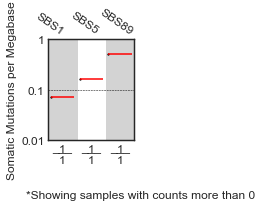

In [81]:
from SigProfilerAssignment import Analyzer as Analyze

Analyze.cosmic_fit ("/data/project/Meningioma/41.Signature/11.PublicData/01.NatGen_whole/output/SBS/NATGEN_WHOLE.SBS96.all", 
                                "/data/project/Meningioma/41.Signature/11.PublicData/01.NatGen_whole/output/Assignment", 
                                input_type="matrix", 
                                cosmic_version=3.3, 
                                exome=False,
                                genome_build="GRCh37", 
                                signature_database=None,
                                exclude_signature_subgroups = [ "Chemotherapy_signatures", "Treatment_signatures", "Artifact_signatures", "Unknown_signatures", "Test2" ],   #  'remove' 가 붙은건 cnvpytor, 없는건 master
                                #exclude_signature_subgroups = [ 'Moore_signatures'],   #  'remove' 가 붙은건 cnvpytor, 없는건 master
                                export_probabilities=False,
                                export_probabilities_per_mutation=False, 
                                make_plots=True,
                                verbose=False)
